# "Parts of form" explorer

developed by Kow Kuroda (kow.kuroda@gmail.com)

History

Created 2024/09/13

Modified 2025/08/01 i) added handling of Englsh WN3 word classification; ii) added gender sub-classification for Irish;

In [104]:
#!pip install -U pyLDAvis
#!pip install -U pandas

In [105]:
## imports
import os, sys
import pprint as pp
import unicodedata

In [106]:
## 一つ上の階層のファイルを見るように設定
sys.path.append(os.path.join(os.path.dirname("__file__"), '..'))

In [107]:
## Cython module の生成 (必要に応じて)
#!python clean setup.py build_ext --inplace

In [108]:
## Cython を使うかどうか
use_Cython = False
if use_Cython:
    %load_ext Cython

In [109]:
## doc settings
doc_types        = [ 'spell', 'sound' ]
doc_type          = doc_types[0]
print(f"doc_type: {doc_type}")

### boundary handling
mark_boundaries     = True
boundary_mark       = "#"
print(f"mark_boundaries with {boundary_mark}: {doc_type}")

## sizes
max_doc_size        = 11
min_doc_size        =  5
print(f"max_doc_size: {max_doc_size}")
print(f"min_doc_size: {min_doc_size}")

doc_type: spell
mark_boundaries with #: spell
max_doc_size: 11
min_doc_size: 5


In [110]:
## term settings
ngram_is_inclusive  = True
inclusion_degree    = None # or 1 # smaller values give better results

## term setting
#ngram_is_skippy       = False
skippy_means_extended = False

gap_mark            = "…"
seg_joint           = ""

### accent handling
suppress_accents    = True
accent_marks        = [ "ˈ", "ˌ" ] 
if doc_type == 'sound':
    if suppress_accents:
        accent_status = "-unaccented"
    else:
        accent_stratus = "-accented"
else:
    accent_status = ""
print(f"accent_status: {accent_status}")

accent_status: 


In [111]:
## select target files
import glob
data_dir1      = "data/open-dict-ipa/data1"
data_dir2      = "data/open-dict-ipa/data1a"
data_dir3      = "data/wn3"
data_dir4      = "data/irish"
target_files   = glob.glob(f"{data_dir1}/*")
target_files2  = glob.glob(f"{data_dir2}/*")
target_files.extend(target_files2)
target_files3  = glob.glob(f"{data_dir3}/*")
target_files.extend(target_files3)
target_files4  = glob.glob(f"{data_dir4}/*")
target_files.extend(target_files4)
pp.pprint(target_files)

['data/open-dict-ipa/data1/yue.csv.gz',
 'data/open-dict-ipa/data1/vi_S.csv.gz',
 'data/open-dict-ipa/data1/de.csv.gz',
 'data/open-dict-ipa/data1/jam.csv.gz',
 'data/open-dict-ipa/data1/ro.csv.gz',
 'data/open-dict-ipa/data1/fa.csv.gz',
 'data/open-dict-ipa/data1/zh_hant.csv.gz',
 'data/open-dict-ipa/data1/sw.csv.gz',
 'data/open-dict-ipa/data1/ar.csv.gz',
 'data/open-dict-ipa/data1/es_MX.csv.gz',
 'data/open-dict-ipa/data1/vi_C.csv.gz',
 'data/open-dict-ipa/data1/ma.csv.gz',
 'data/open-dict-ipa/data1/en_US.csv',
 'data/open-dict-ipa/data1/fi.csv.gz',
 'data/open-dict-ipa/data1/eo.csv.gz',
 'data/open-dict-ipa/data1/fr_QC.csv.gz',
 'data/open-dict-ipa/data1/es_ES.csv.gz',
 'data/open-dict-ipa/data1/en_US.csv.gz',
 'data/open-dict-ipa/data1/en_UK.csv.gz',
 'data/open-dict-ipa/data1/nb.csv.gz',
 'data/open-dict-ipa/data1/nl.csv.gz',
 'data/open-dict-ipa/data1/sv.csv.gz',
 'data/open-dict-ipa/data1/or.csv.gz',
 'data/open-dict-ipa/data1/zh_hans.csv.gz',
 'data/open-dict-ipa/data1/fr_FR.

In [112]:
## select language
## a key must be part of a file name 
target_lang_dict = {    'en_US' : 'English (US)',
                        'en_UK' : 'English (UK)',
                        'en_N_only' : 'English noun (WN)',
                        'en_V_only' : 'English verb (WN)',
                        'en_A_only' : 'English adj (WN)',
                        'en_R_only' : 'English adv (WN)',
                        'ar'    : 'Arabic',
                        'de'    : 'German',
                        'de_N_only' : 'German noun',
                        'de_non_N_only' : 'German non-noun',
                        'eo'    : 'Esperanto',
                        'es_ES' : 'Spanish (Spain)',
                        'es_MX' : 'Spanish (Mexico)',
                        'fi'    : 'Finnish',
                        'fr_FR' : 'French (France)',
                        'fr_QC' : 'French (Quebec)',
                        'is'    : 'Icelandic',
                        'ir'    : 'Irish',
                        'nl'    : 'Dutch',
                        'ro'    : 'Romanian',
                        'sw'    : 'Swahili' }
## proper language selection
target_lang_keys = [    'en_US', # 0
                        'en_UK', # 1
                        'en_N_only', # 2
                        'en_V_only', # 3
                        'en_A_only', # 4
                        'en_R_only', # 5
                        'ar', # 6
                        'de', # 7
                        'de_N_only', # 8
                        'de_non_N_only', # 9
                        'eo', 'es_ES', 'es_MX',
                        'fi', 'fr_FR', 'fr_QC',
                        'is', 'nl', 'ro', 'sw',
                        'ir' # This lacks sound
                    ]
## check
target_lang_key  = target_lang_keys[-1]
print(f"target_lang_key: {target_lang_key}")
target_lang_name = target_lang_dict[target_lang_key]
print(f"target lang: {target_lang_name} [{target_lang_key}]")

target_lang_key: ir
target lang: Irish [ir]


In [113]:
## select word class
selects_word_class = True
#
target_word_classes = [ 'N_only', 'A_only', 'R_only', 'V_only' ] # R_only is not available for Irish
if not selects_word_class:
    target_word_class = None
else:
    #target_word_class = target_word_classes[0:1] + target_word_classes[-1:]
    target_word_class = target_word_classes[-1]
print(f"target_word_class: {target_word_class}")
#
if selects_word_class:
    lang_key = target_lang_key.split("_")[0]
    print(f"lang_key: {lang_key}")
    print(f"target_word_class: {target_word_class}")
    if type(target_word_class) == 'list':
        target_files = [ f for f in target_files if any(wc in f for wc in target_word_class) and lang_key in f ]
    else:
        target_files = [ f for f in target_files if target_word_class in f and lang_key in f ]
##
pp.pprint(target_files)

target_word_class: V_only
lang_key: ir
target_word_class: V_only
['data/irish/irish-spell-V_only.csv']


In [114]:
## get source data from files
import pandas as pd
import gzip

for target_file in target_files:
    print(f"processing: {target_file}")
    if target_lang_key == "ir":
        col_names = ['spell', 'POS']
    else:
        col_names = ['spell', 'sound']

    ##
    if target_file.endswith(".gz"):
        with gzip.open(target_file, "rt") as f:
            raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
    else:
        with open(target_file, "rt") as f:
            raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )

    ## normalize characters
    raw_df['spell'] = raw_df['spell'].apply(lambda x: unicodedata.normalize('NFC', str(x)))

    ## modify sound
    try:
        sounds = raw_df['sound'].apply(lambda x: x.strip('/') )
        sounds = [ x.split("/,")[0] for x in sounds ] # picks up only the first of multiple entries
        raw_df['sound'] = sounds
    except (AttributeError, KeyError):
        pass
    #
raw_df.sample(10)

processing: data/irish/irish-spell-V_only.csv


,spell,POS
1276,eamhnaigh,verb
1210,dochraigh,verb
2209,mionnaigh,verb
2151,meabhraigh,verb
2720,scrábáil,verb
912,cros,verb
2950,sprúill,verb
1237,dreach,verb
949,cuimil,verb
462,breisigh,verb


In [115]:
## select gender
selects_gender = True

target_genders = [ 'masc', 'fem', 'neu' ]
target_gender = target_genders[0]
print(f"target_gender: {target_gender}")
#
raw_df_origin = raw_df.copy()
if selects_gender and target_word_class in ['N_only']:
    raw_df = raw_df_origin[raw_df_origin['POS'].apply(lambda x: x[:len(x)-1]) == target_gender]
else:
    target_gender = None
#
raw_df

target_gender: masc


,spell,POS
0,Gaelaigh,verb
1,Laidinigh,verb
2,X-ghathaigh,verb
3,abair,verb
4,achainigh,verb
...,...,...
3354,válsáil,verb
3355,vótáil,verb
3356,zipeáil,verb
3357,zónáil,verb


In [116]:
## source sampling
source_sampling          = True
source_sampling_rate     = 0.5
source_sampling_max_size = 3000
len(raw_df)
if source_sampling:
	print(f"source sampling applied")
	if len(raw_df) >= source_sampling_max_size:
		source_sampling_n = source_sampling_max_size
	else:
		source_sampling_n = round(len(raw_df) * source_sampling_rate)
	raw_df = raw_df.sample(source_sampling_n)
else:
	source_sampling_n = None

## remove accent marking
if suppress_accents:
	try:
		raw_df['sound'] = raw_df['sound'].apply(lambda x: "".join([ y for y in list(x) if y not in accent_marks ]))
	except KeyError:
		pass
## add boudary marks
if mark_boundaries:
	raw_df['spell'] = raw_df['spell'].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
	try:
		raw_df['sound'] = raw_df['sound'].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
	except KeyError:
		pass
#
print(raw_df)

source sampling applied
                spell   POS
2770           #séid#  verb
1039  #deicrimintigh#  verb
2023           #léas#  verb
187        #athdháil#  verb
624            #ciap#  verb
...               ...   ...
59      #airgeadaigh#  verb
216        #athghabh#  verb
281         #athrígh#  verb
520       #cabhraigh#  verb
3233      #traschuir#  verb

[3000 rows x 2 columns]


In [117]:
## generate 1-grams for spell and sound
## spell
raw_df['sp_1gram'] = raw_df['spell'].apply(lambda x: list(str(x)))
# add column of size
raw_df['sp_size'] = raw_df['sp_1gram'].apply(lambda x: len(x))
# add column of count of '-' inside
raw_df['hyphen'] = raw_df['sp_1gram'].apply(lambda x: list(x).count("-"))
# add column of count of '.' inside
raw_df['period'] = raw_df['sp_1gram'].apply(lambda x: list(x).count("."))
## sound
# takes the first entry, removes '/' around
try:
    raw_df['sn_1gram'] = raw_df['sound'].apply(lambda x: list(x) )
except (TypeError, KeyError):
    pass
# add column of size
try:
    raw_df['sn_size'] = raw_df['sn_1gram'].apply(lambda x: len(x))
except KeyError:
    pass
## check
raw_df

,spell,POS,sp_1gram,sp_size,hyphen,period
2770,#séid#,verb,"[#, s, é, i, d, #]",6,0,0
1039,#deicrimintigh#,verb,"[#, d, e, i, c, r, i, m, i, n, t, i, g, h, #]",15,0,0
2023,#léas#,verb,"[#, l, é, a, s, #]",6,0,0
187,#athdháil#,verb,"[#, a, t, h, d, h, á, i, l, #]",10,0,0
624,#ciap#,verb,"[#, c, i, a, p, #]",6,0,0
...,...,...,...,...,...,...
59,#airgeadaigh#,verb,"[#, a, i, r, g, e, a, d, a, i, g, h, #]",13,0,0
216,#athghabh#,verb,"[#, a, t, h, g, h, a, b, h, #]",10,0,0
281,#athrígh#,verb,"[#, a, t, h, r, í, g, h, #]",9,0,0
520,#cabhraigh#,verb,"[#, c, a, b, h, r, a, i, g, h, #]",11,0,0


In [118]:
## filtering raw_data by size
print(f"term_class: {doc_type}")
if "spell" == doc_type:
    df_filtered = raw_df[ (raw_df['sp_size'] <= max_doc_size) & (raw_df['sp_size'] >= min_doc_size) & (raw_df['hyphen'] == 0) & (raw_df['period'] == 0) ]
else:
    df_filtered = raw_df[ (raw_df['sn_size'] <= max_doc_size) & (raw_df['sn_size'] >= min_doc_size) ]
#
df_filtered

term_class: spell


,spell,POS,sp_1gram,sp_size,hyphen,period
2770,#séid#,verb,"[#, s, é, i, d, #]",6,0,0
2023,#léas#,verb,"[#, l, é, a, s, #]",6,0,0
187,#athdháil#,verb,"[#, a, t, h, d, h, á, i, l, #]",10,0,0
624,#ciap#,verb,"[#, c, i, a, p, #]",6,0,0
1484,#fordhing#,verb,"[#, f, o, r, d, h, i, n, g, #]",10,0,0
...,...,...,...,...,...,...
2403,#plátáil#,verb,"[#, p, l, á, t, á, i, l, #]",9,0,0
216,#athghabh#,verb,"[#, a, t, h, g, h, a, b, h, #]",10,0,0
281,#athrígh#,verb,"[#, a, t, h, r, í, g, h, #]",9,0,0
520,#cabhraigh#,verb,"[#, c, a, b, h, r, a, i, g, h, #]",11,0,0


In [119]:
## second sampling if needed
second_sampling          = False
second_sampling_rate     = 0.7
len(df_filtered)
if second_sampling:
    df = df_filtered.sample(round(len(df_filtered) * second_sampling_rate))
else:
    df = df_filtered
len(df)

2078

# Functions

In [120]:
def add_ngram_to_df(dfx, n_for_ngram: int, skippy: bool, prefix: str = "", seg_joint: str = "", missing_mark: str = gap_mark, max_distance = None, inclusive: bool = ngram_is_inclusive, inclusion_degree = None, use_Cython: bool = False, check: bool = False):
    """
    generic function for adding n-gram column to df with a specified n for ngram
    """
    ## variables
    source_var = f"{prefix}1gram"
    print(f"source_var: {source_var}")
    if skippy:
        target_var = f"{prefix}sk{n_for_ngram}gram"
    else:
        target_var = f"{prefix}{n_for_ngram}gram"
    print(f"target_var: {target_var}")
    
    ##
    unigrams = dfx[source_var]
    if use_Cython:
        import cy_gen_ngrams
        if skippy:
            ngrams = [ [seg_joint.join(x) for x in cy_gen_ngrams.cy_gen_skippy_ngrams(x, n = n_for_ngram, missing_mark = missing_mark, max_distance = max_distance, check = check)] for x in unigrams ]
        else:
            ngrams = [ [seg_joint.join(x) for x in cy_gen_ngrams.cy_gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check)] for x in unigrams ]
    else:
        import gen_ngrams
        if skippy:
            ngrams = [ gen_ngrams.gen_skippy_ngrams(x, n = n_for_ngram, sep = seg_joint, missing_mark = missing_mark, max_distance = max_distance, check = check) for x in unigrams ]
        else:
            ngrams = [ gen_ngrams.gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check) for x in unigrams ]
    ## 包括的 n-gramの生成
    if inclusive:
        if inclusion_degree is None:
            min_size = 1
        else:
            min_size = (n_for_ngram - inclusion_degree)
        print(f"min_size: {min_size}")
        assert min_size >= 0
        if skippy and n_for_ngram > 2:
            supplement_var = f"{prefix}sk{n_for_ngram - 1}gram"
        else:
            supplement_var = f"{prefix}{n_for_ngram - 1}gram"
        print(f"supplement_var: {supplement_var}")
        for i, g in enumerate(ngrams):
            supplement = [ x for x in list(dfx[supplement_var])[i] if len(x) >= min_size ]
            if len(supplement) > 0:
                g.extend(supplement)
    ## 変数の追加
    dfx[target_var] = ngrams
    ## check result
    print(dfx[target_var])

In [121]:
def get_terms_by_freq_rank(dfx, rank_range: tuple, prefix: str = "", n_for_ngram: int = 2, skippy: bool = False, gap_mark: str = "…", check = False):
    "return list of most N frequent terms"
    import collections
    ## define variables
    if skippy:
        if skippy_means_extended:
            skippiness = "xsk"
        else:
            skippiness = "sk"
    else:
        skippiness = "" 
    var_name = f'{prefix}{skippiness}{n_for_ngram}gram'
    if check:
        print(f"var_name: {var_name}")
    ## main
    G = [ ]
    [ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_for_ngram]) for L in dfx[var_name] ]
    if check:
        print(G)
    ## filtering data
    highest_rank = min(rank_range)
    lowest_rank  = max(rank_range)
    if check:
        print(f"highest_rank: {highest_rank}; lowest_rank: {lowest_rank}")
    R = collections.Counter(G).most_common(lowest_rank)
    R = R[(highest_rank - 1):]
    if check:
        print(R)
    ## return
    return R

In [122]:
def show_terms_with_ranking(ranking, rank_range: tuple, n_for_ngram: int, skippy: bool, prefix: str = "", lang: str = target_lang_name, word_class: str = target_word_class, gender: str = target_gender, check = False):
    "display terms with a given frequency rank range"
    ## imports
    import matplotlib.pyplot as plt
    ## variables
    highest_rank = min(rank_range)
    lowest_rank  = max(rank_range)
    if skippy:
        if skippy_means_extended:
            skippiness = "xsk"
        else:
            skippiness = "sk"
    else:
        skippiness = ""
    target_var_name = f"{prefix}{skippiness}{n_for_ngram}g"

    ## get freq data
    ranking = sorted(ranking, key = lambda x: x[1], reverse = False)
    terms, freqs = [ ], [ ]
    for x in ranking:
        term, freq = x[0], x[1]
        if len(term) > 0 and freq > 0:
            terms.append(term)
            freqs.append(freq)

    ## plot
    plt.figure(figsize = (6, 0.25 * len(terms)))
    plt.autoscale(enable = True, axis = 'y', tight = True)
    plt.barh(terms, freqs)
    if gender is None:
        title_val = f"Freq-ranked distribution [rank {highest_rank} – rank {lowest_rank}] of {target_var_name} from\n{lang} (sample {source_sampling_n} from word_class: {word_class}) "
    else:
        title_val = f"Freq-ranked distribution [rank {highest_rank} - rank {lowest_rank}] of {target_var_name} from\n{lang} (sample {source_sampling_n} from word_class: {word_class} with gender: {gender}) "
    plt.title(title_val)
    plt.plot()

# Main

In [123]:
# frequency rank range for terms to show
highest_freq_rank_for_terms_to_show = 1
lowest_freq_rank_for_terms_to_show  = 100
rank_range  = (highest_freq_rank_for_terms_to_show, lowest_freq_rank_for_terms_to_show)
print(f"rank_range: {rank_range}")

rank_range: (1, 100)


## Spell

### Non-skippy spell

In [124]:
## spell 2grams
add_ngram_to_df(df, n_for_ngram = 2, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_2gram
min_size: 1
supplement_var: sp_1gram
2770               [#s, sé, éi, id, d#, #, s, é, i, d, #]
2023               [#l, lé, éa, as, s#, #, l, é, a, s, #]
187     [#a, at, th, hd, dh, há, ái, il, l#, #, a, t, ...
624                [#c, ci, ia, ap, p#, #, c, i, a, p, #]
1484    [#f, fo, or, rd, dh, hi, in, ng, g#, #, f, o, ...
                              ...                        
2403    [#p, pl, lá, át, tá, ái, il, l#, #, p, l, á, t...
216     [#a, at, th, hg, gh, ha, ab, bh, h#, #, a, t, ...
281     [#a, at, th, hr, rí, íg, gh, h#, #, a, t, h, r...
520     [#c, ca, ab, bh, hr, ra, ai, ig, gh, h#, #, c,...
3233    [#t, tr, ra, as, sc, ch, hu, ui, ir, r#, #, t,...
Name: sp_2gram, Length: 2078, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_3301/2238270198.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


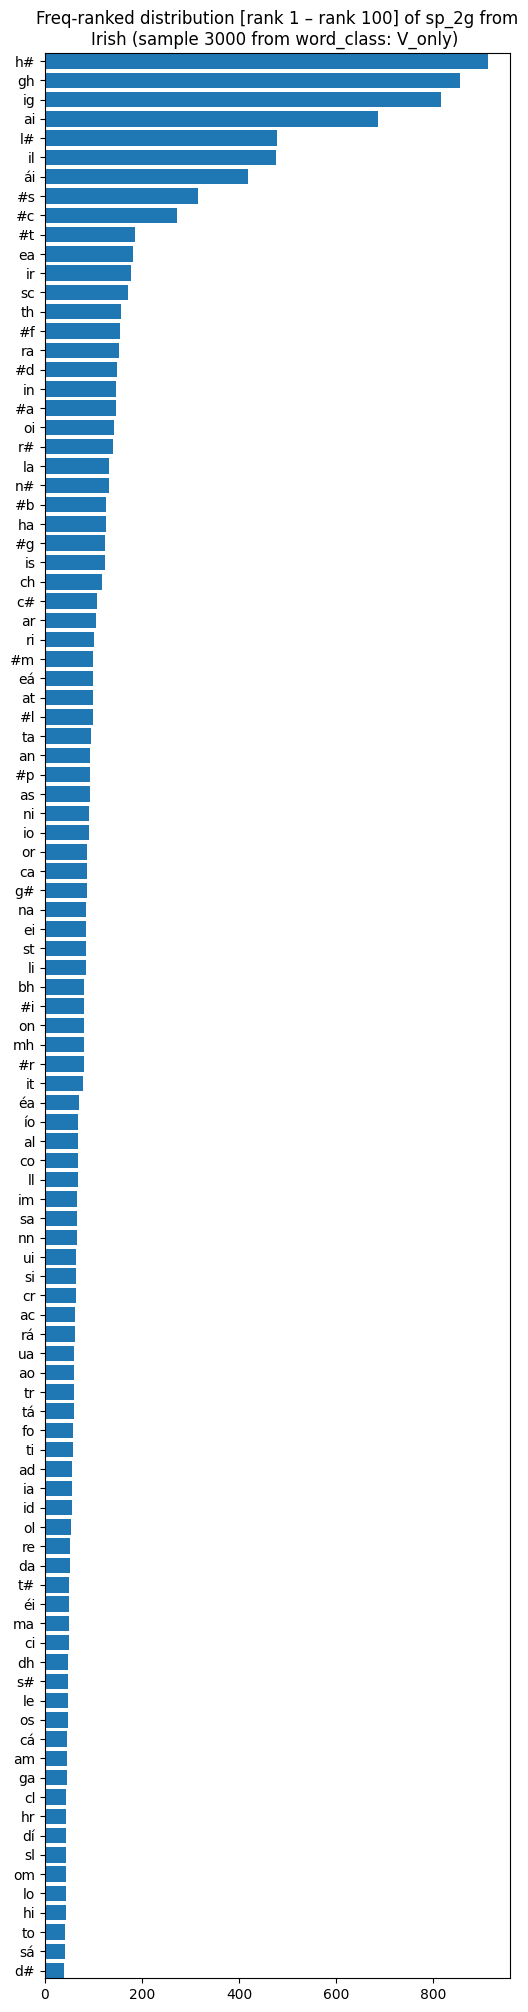

In [125]:
## frequency-ranked view
skippy = False
prefix = "sp_"
n_local = 2
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [126]:
## spell 3grams
add_ngram_to_df(df, n_for_ngram = 3, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_3gram
min_size: 1
supplement_var: sp_2gram
2770    [#sé, séi, éid, id#, #s, sé, éi, id, d#, #, s,...
2023    [#lé, léa, éas, as#, #l, lé, éa, as, s#, #, l,...
187     [#at, ath, thd, hdh, dhá, hái, áil, il#, #a, a...
624     [#ci, cia, iap, ap#, #c, ci, ia, ap, p#, #, c,...
1484    [#fo, for, ord, rdh, dhi, hin, ing, ng#, #f, f...
                              ...                        
2403    [#pl, plá, lát, átá, tái, áil, il#, #p, pl, lá...
216     [#at, ath, thg, hgh, gha, hab, abh, bh#, #a, a...
281     [#at, ath, thr, hrí, ríg, ígh, gh#, #a, at, th...
520     [#ca, cab, abh, bhr, hra, rai, aig, igh, gh#, ...
3233    [#tr, tra, ras, asc, sch, chu, hui, uir, ir#, ...
Name: sp_3gram, Length: 2078, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_3301/2238270198.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


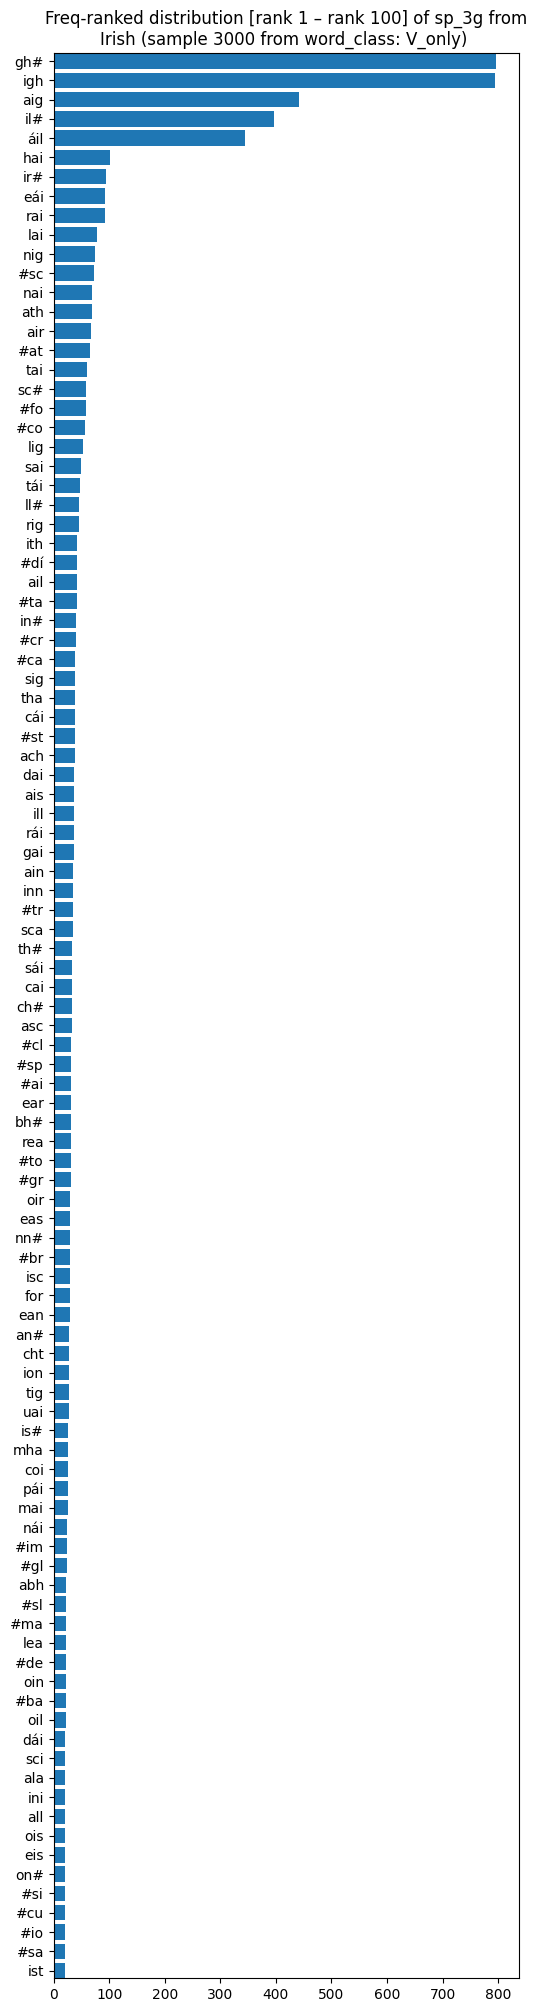

In [127]:
## frequency-ranke view
skippy = False
prefix = "sp_"
n_local = 3
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [128]:
## spell 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_4gram
min_size: 1
supplement_var: sp_3gram
2770    [#séi, séid, éid#, #sé, séi, éid, id#, #s, sé,...
2023    [#léa, léas, éas#, #lé, léa, éas, as#, #l, lé,...
187     [#ath, athd, thdh, hdhá, dhái, háil, áil#, #at...
624     [#cia, ciap, iap#, #ci, cia, iap, ap#, #c, ci,...
1484    [#for, ford, ordh, rdhi, dhin, hing, ing#, #fo...
                              ...                        
2403    [#plá, plát, látá, átái, táil, áil#, #pl, plá,...
216     [#ath, athg, thgh, hgha, ghab, habh, abh#, #at...
281     [#ath, athr, thrí, hríg, rígh, ígh#, #at, ath,...
520     [#cab, cabh, abhr, bhra, hrai, raig, aigh, igh...
3233    [#tra, tras, rasc, asch, schu, chui, huir, uir...
Name: sp_4gram, Length: 2078, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_3301/2238270198.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


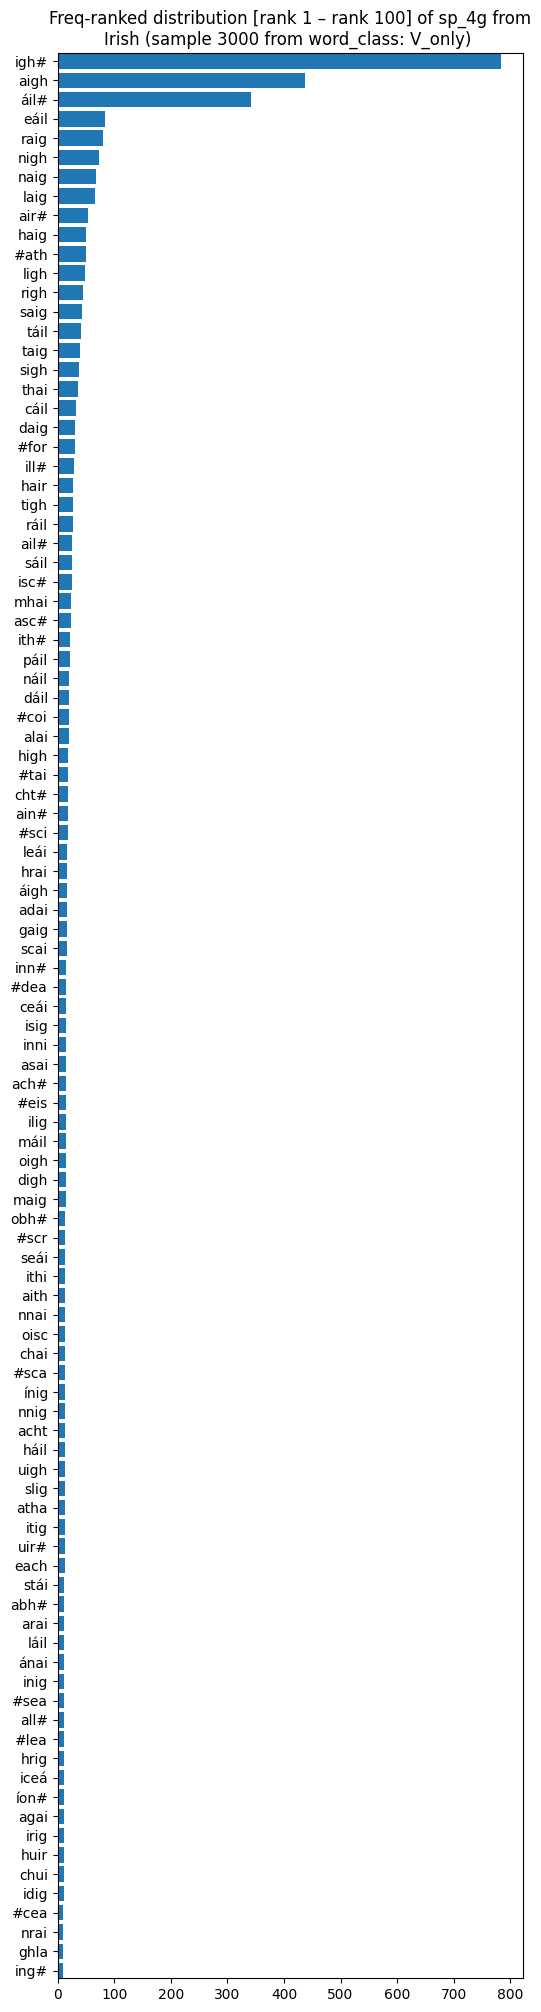

In [129]:
## frequency-ranke view
skippy = False
prefix = "sp_"
n_local = 4
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [130]:
## spell 5grams
add_ngram_to_df(df, n_for_ngram = 5, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_5gram
min_size: 1
supplement_var: sp_4gram
2770    [#séid, séid#, #séi, séid, éid#, #sé, séi, éid...
2023    [#léas, léas#, #léa, léas, éas#, #lé, léa, éas...
187     [#athd, athdh, thdhá, hdhái, dháil, háil#, #at...
624     [#ciap, ciap#, #cia, ciap, iap#, #ci, cia, iap...
1484    [#ford, fordh, ordhi, rdhin, dhing, hing#, #fo...
                              ...                        
2403    [#plát, plátá, látái, átáil, táil#, #plá, plát...
216     [#athg, athgh, thgha, hghab, ghabh, habh#, #at...
281     [#athr, athrí, thríg, hrígh, rígh#, #ath, athr...
520     [#cabh, cabhr, abhra, bhrai, hraig, raigh, aig...
3233    [#tras, trasc, rasch, aschu, schui, chuir, hui...
Name: sp_5gram, Length: 2078, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_3301/2238270198.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


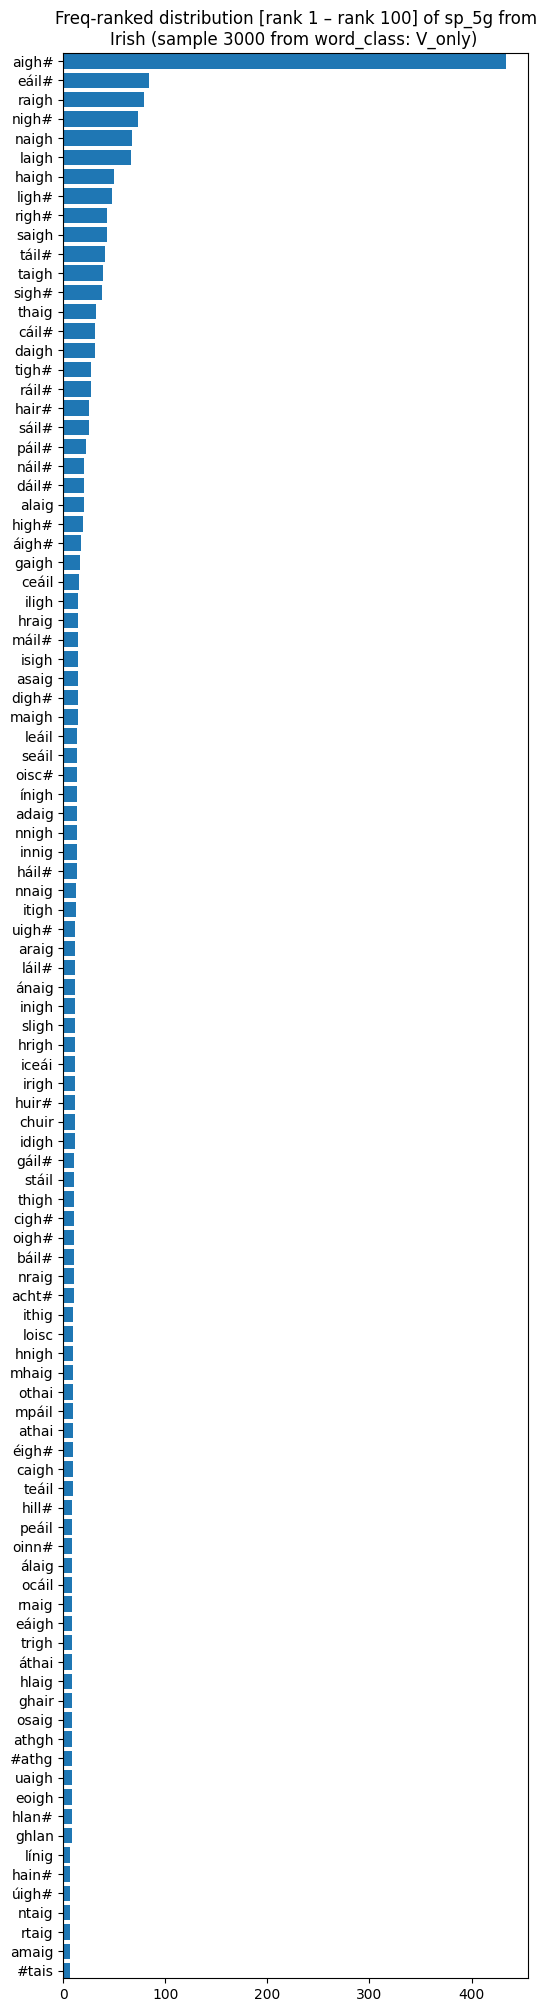

In [131]:
## frequency-rank view
skippy = False
prefix = "sp_"
n_local = 5
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

### skippy spell

In [132]:
## spell skippy 2grams
add_ngram_to_df(df, n_for_ngram = 2, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_sk2gram
min_size: 1
supplement_var: sp_1gram
2770    [#s, #…é, #…i, #…d, #…#, sé, s…i, s…d, s…#, éi...
2023    [#l, #…é, #…a, #…s, #…#, lé, l…a, l…s, l…#, éa...
187     [#a, #…t, #…h, #…d, #…h, #…á, #…i, #…l, #…#, a...
624     [#c, #…i, #…a, #…p, #…#, ci, c…a, c…p, c…#, ia...
1484    [#f, #…o, #…r, #…d, #…h, #…i, #…n, #…g, #…#, f...
                              ...                        
2403    [#p, #…l, #…á, #…t, #…á, #…i, #…l, #…#, pl, p…...
216     [#a, #…t, #…h, #…g, #…h, #…a, #…b, #…h, #…#, a...
281     [#a, #…t, #…h, #…r, #…í, #…g, #…h, #…#, at, a…...
520     [#c, #…a, #…b, #…h, #…r, #…a, #…i, #…g, #…h, #...
3233    [#t, #…r, #…a, #…s, #…c, #…h, #…u, #…i, #…r, #...
Name: sp_sk2gram, Length: 2078, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_3301/2238270198.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


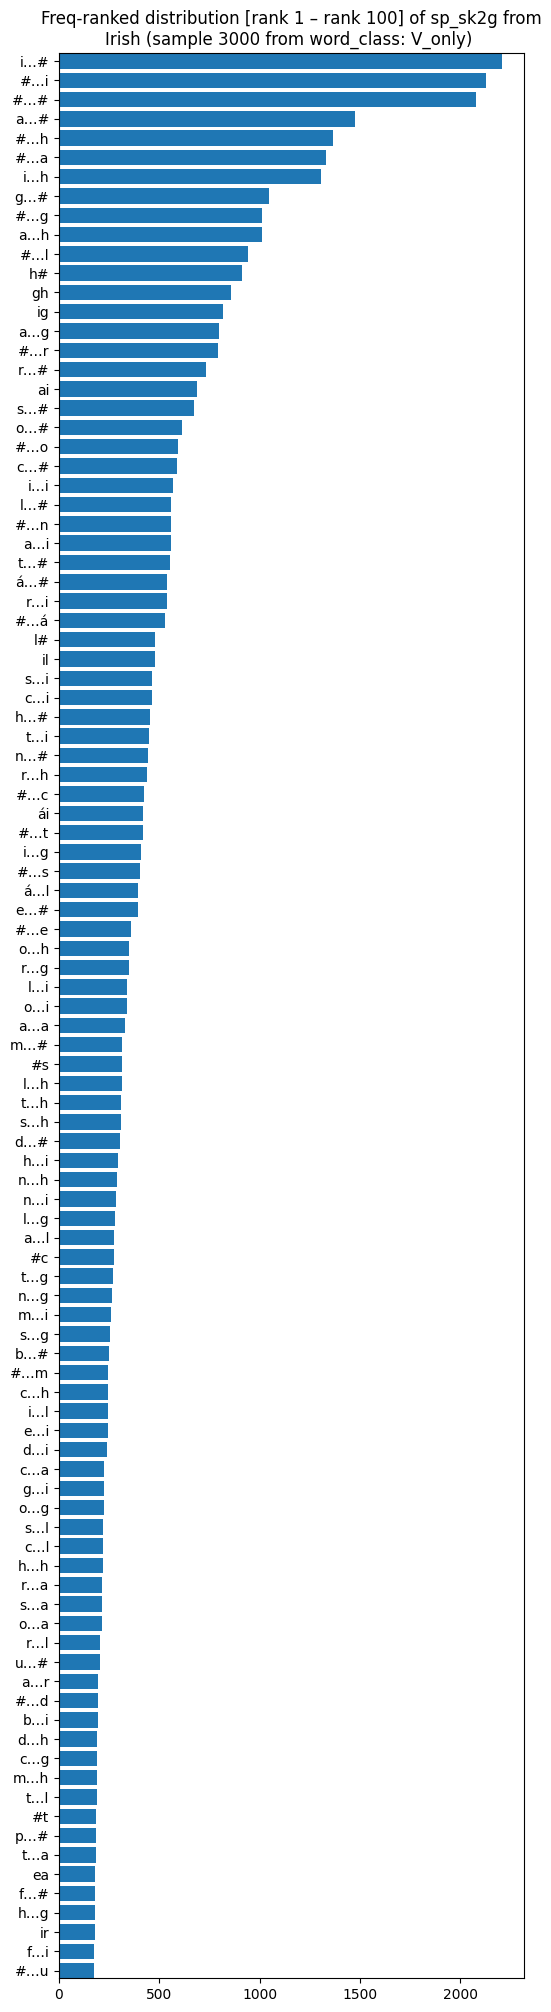

In [133]:
## frequency-ranked view
skippy = True
prefix = "sp_"
n_local = 2
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [134]:
## spell skippy 3grams
add_ngram_to_df(df, n_for_ngram = 3, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_sk3gram
min_size: 1
supplement_var: sp_sk2gram
2770    [#sé, #s…i, #s…d, #s…#, #…éi, #…é…d, #…é…#, #…...
2023    [#lé, #l…a, #l…s, #l…#, #…éa, #…é…s, #…é…#, #…...
187     [#at, #a…h, #a…d, #a…h, #a…á, #a…i, #a…l, #a…#...
624     [#ci, #c…a, #c…p, #c…#, #…ia, #…i…p, #…i…#, #…...
1484    [#fo, #f…r, #f…d, #f…h, #f…i, #f…n, #f…g, #f…#...
                              ...                        
2403    [#pl, #p…á, #p…t, #p…á, #p…i, #p…l, #p…#, #…lá...
216     [#at, #a…h, #a…g, #a…h, #a…a, #a…b, #a…h, #a…#...
281     [#at, #a…h, #a…r, #a…í, #a…g, #a…h, #a…#, #…th...
520     [#ca, #c…b, #c…h, #c…r, #c…a, #c…i, #c…g, #c…h...
3233    [#tr, #t…a, #t…s, #t…c, #t…h, #t…u, #t…i, #t…r...
Name: sp_sk3gram, Length: 2078, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_3301/2238270198.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


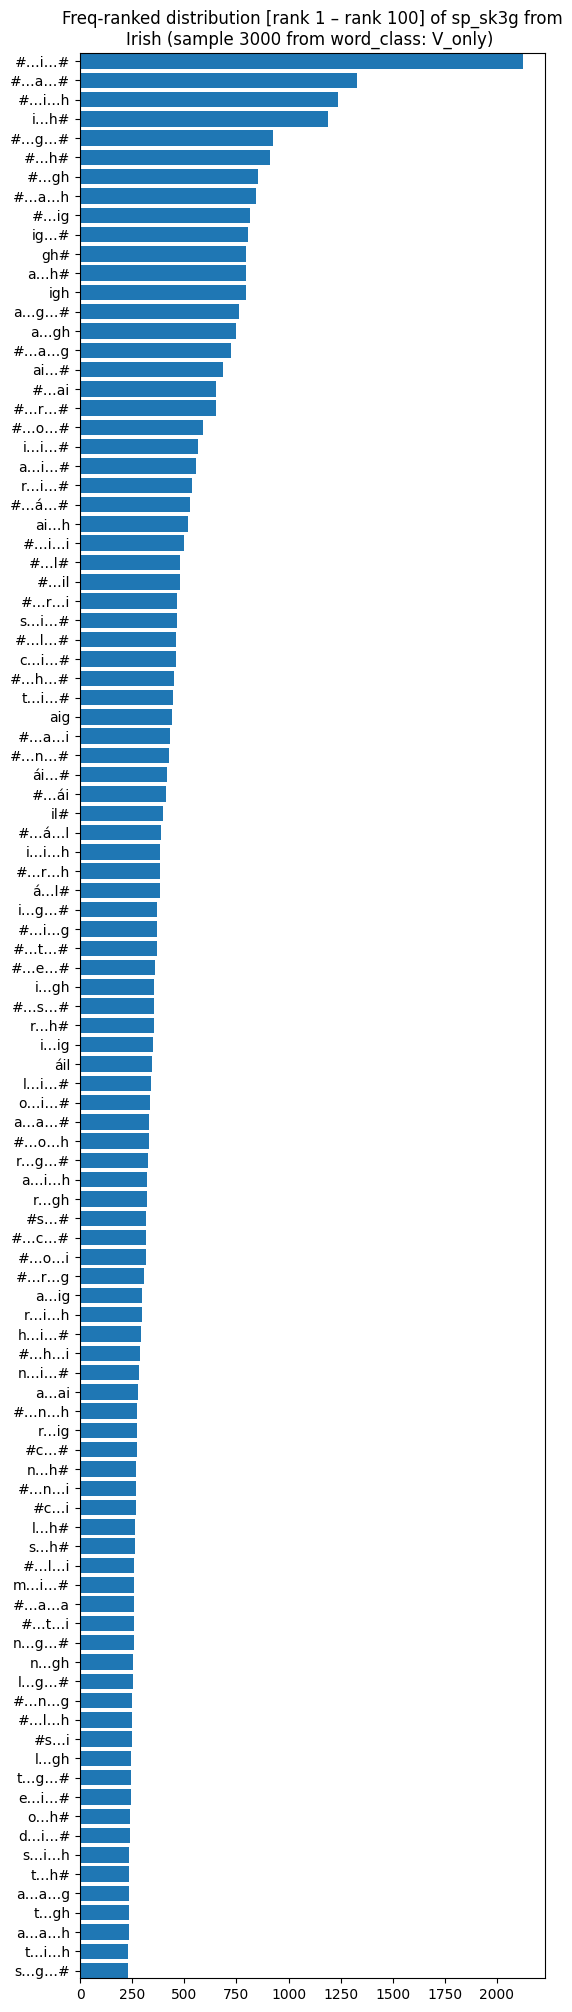

In [135]:
## frequency-ranked view
skippy = True
prefix = "sp_"
n_local = 3
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [136]:
## spell skippy 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_sk4gram
min_size: 1
supplement_var: sp_sk3gram
2770    [#séi, #sé…d, #sé…#, #s…id, #s…i…#, #s…d#, #…é...
2023    [#léa, #lé…s, #lé…#, #l…as, #l…a…#, #l…s#, #…é...
187     [#ath, #at…d, #at…h, #at…á, #at…i, #at…l, #at…...
624     [#cia, #ci…p, #ci…#, #c…ap, #c…a…#, #c…p#, #…i...
1484    [#for, #fo…d, #fo…h, #fo…i, #fo…n, #fo…g, #fo…...
                              ...                        
2403    [#plá, #pl…t, #pl…á, #pl…i, #pl…l, #pl…#, #p…á...
216     [#ath, #at…g, #at…h, #at…a, #at…b, #at…h, #at…...
281     [#ath, #at…r, #at…í, #at…g, #at…h, #at…#, #a…h...
520     [#cab, #ca…h, #ca…r, #ca…a, #ca…i, #ca…g, #ca…...
3233    [#tra, #tr…s, #tr…c, #tr…h, #tr…u, #tr…i, #tr…...
Name: sp_sk4gram, Length: 2078, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_3301/2238270198.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


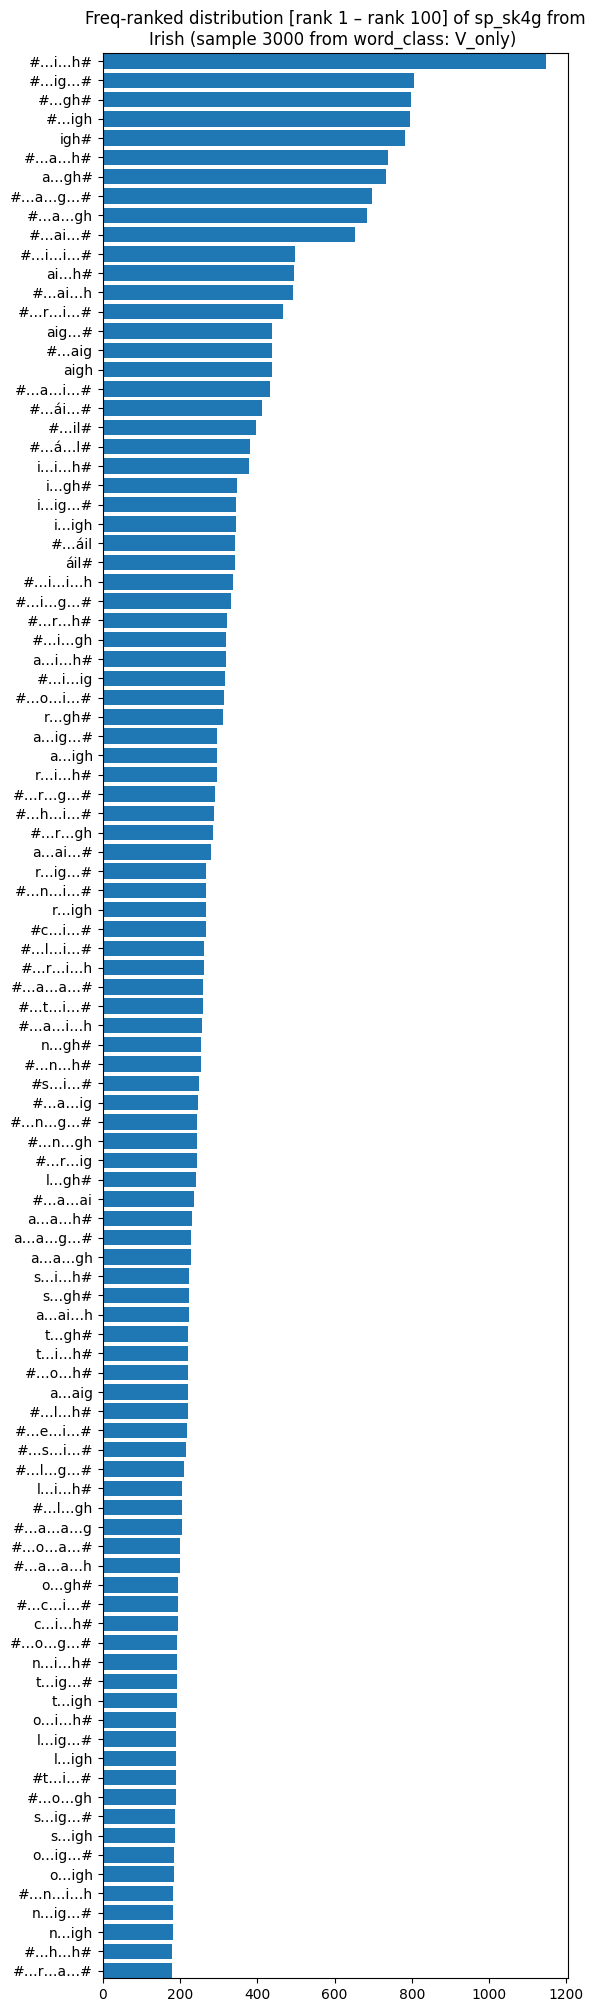

In [137]:
## frequency-ranked view
skippy = True
prefix = "sp_"
n_local = 4
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [138]:
## spell skippy 5grams
add_ngram_to_df(df, n_for_ngram = 5, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_sk5gram
min_size: 1
supplement_var: sp_sk4gram
2770    [#séid, #séi…#, #sé…d#, #s…id#, #…éid#, séid#,...
2023    [#léas, #léa…#, #lé…s#, #l…as#, #…éas#, léas#,...
187     [#athd, #ath…h, #ath…á, #ath…i, #ath…l, #ath…#...
624     [#ciap, #cia…#, #ci…p#, #c…ap#, #…iap#, ciap#,...
1484    [#ford, #for…h, #for…i, #for…n, #for…g, #for…#...
                              ...                        
2403    [#plát, #plá…á, #plá…i, #plá…l, #plá…#, #pl…tá...
216     [#athg, #ath…h, #ath…a, #ath…b, #ath…h, #ath…#...
281     [#athr, #ath…í, #ath…g, #ath…h, #ath…#, #at…rí...
520     [#cabh, #cab…r, #cab…a, #cab…i, #cab…g, #cab…h...
3233    [#tras, #tra…c, #tra…h, #tra…u, #tra…i, #tra…r...
Name: sp_sk5gram, Length: 2078, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_3301/2238270198.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


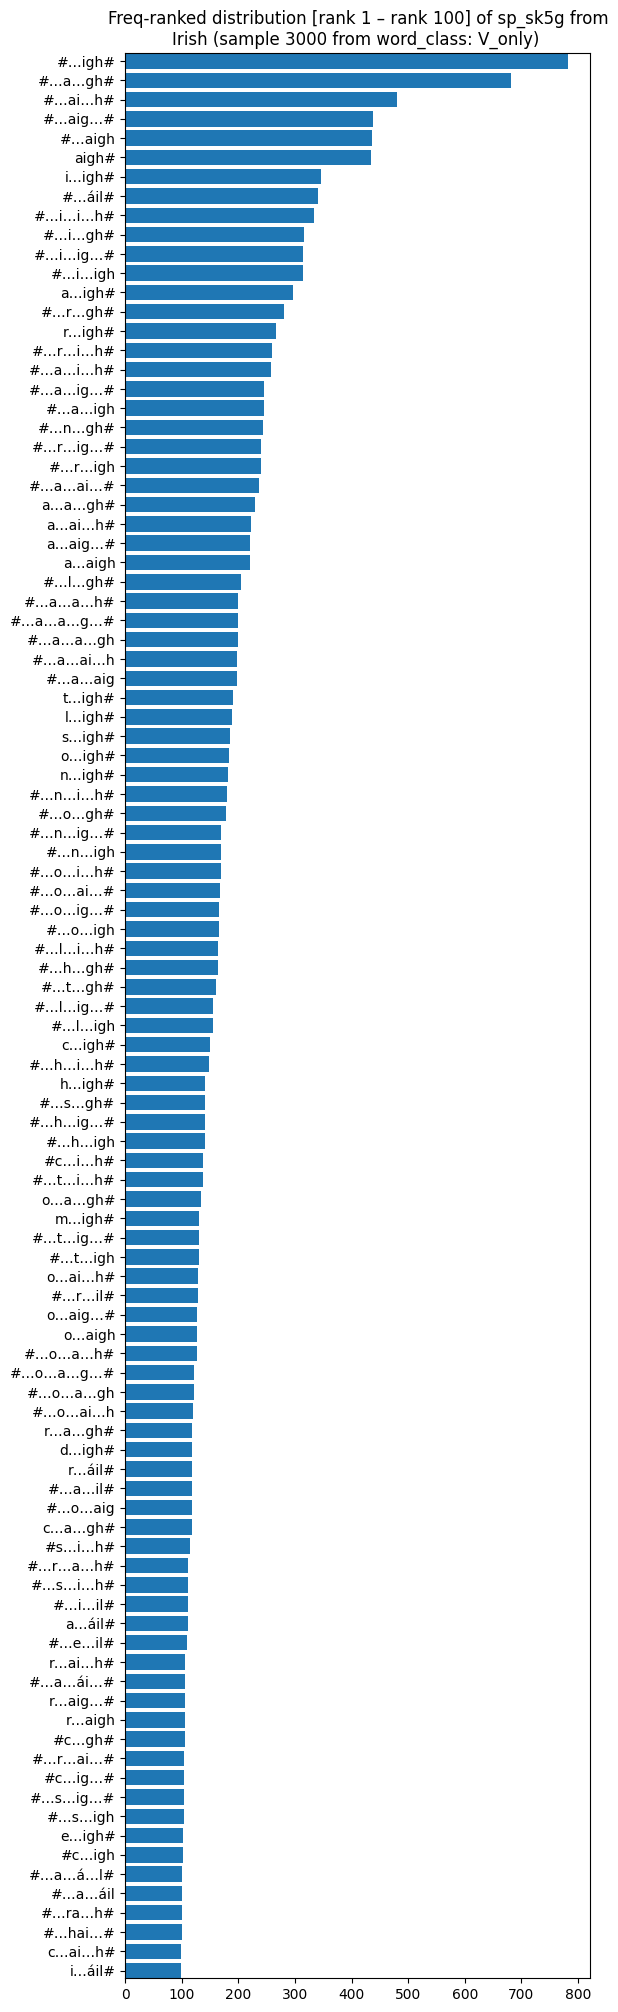

In [139]:
## frequency-ranked view
skippy = True
prefix = "sp_"
n_local = 5
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

## Sound

In [140]:
## stop for unimplemented language
if target_lang_name in [ 'Irish' ]:
    import sys
    sys.exit()

SystemExit: 

/Users/kowk/opt/miniconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Non-skippy sound

In [ ]:
## sound 2grams
add_ngram_to_df(df, n_for_ngram = 2, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [ ]:
## frequency-ranked view
skippy = False
prefix = "sn_"
n_local = 2
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [ ]:
## sound 3grams
add_ngram_to_df(df, n_for_ngram = 3, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [ ]:
## frequency-ranked view
skippy = False
prefix = "sn_"
n_local = 3
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [ ]:
## sound 4grams
add_ngram_to_df(df, n_for_ngram = 4, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [ ]:
## frequency-ranked view
skippy = False
prefix = "sn_"
n_local = 4
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [ ]:
## sound 5grams
add_ngram_to_df(df, n_for_ngram = 5, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [ ]:
## frequency-ranked view
skippy = False
prefix = "sn_"
n_local = 5
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

### skippy sound

In [ ]:
## sound skippy 2grams
add_ngram_to_df(df, n_for_ngram = 2, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [ ]:
## frequency-ranked view
skippy = True
prefix = "sn_"
n_local = 2
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [ ]:
## sound skippy 3grams
add_ngram_to_df(df, n_for_ngram = 3, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [ ]:
## frequency-ranked view
skippy = True
prefix = "sn_"
n_local = 3
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [ ]:
## sound skippy 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sn_", skippy = True, inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [ ]:
## frequency-ranked view
skippy = True
prefix = "sn_"
n_local = 4
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [ ]:
## sound skippy 5grams
add_ngram_to_df(df, n_for_ngram = 5, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [ ]:
## frequency-ranked view
skippy = True
prefix = "sn_"
n_local = 5
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)